# LightBGMによるモデリング

決定木系の機械学習法。　

## 機械学習手法の分類

- 学習手法
    - 決定木
        - ランダムフォレスト
            - 決定木を複数作成して組み合わせる方法。
        - Gradient Boosting Decision Tree
            - 決定木を逐次的に更新していく方法
                - LightGBM
                - XGBoost
    - ニューラルネットワーク
    - etc

## 過学習と学習不足

予測タスクにおける機械学習は、学習データから目的変数に対する説明変数のモデルを作成し、テストデータに適用するもの。

既知のデータに過剰に適用しすぎると、未知のデータに対する精度が下がる可能性がある。これを過学習という。
学習が不十分であれば、学習不足という。

過学習を避ける範囲で学習を止めるチューニングをすることが機械学習において肝要となる。

## チューニング方法

過学習をさけるために学習データから検証データを分離する方法。

- ホールドアウト
    - 一定比率で学習データと検証データを分ける方法。
    - 検証データに対する精度を見ながらモデルの学習を進める場合、検証データでの予測に過度に適合してしまう可能性がある。
- クロスバリデーション
    - ある程度データがある場合に向いている。
    - データ全体を任意のブロックに分割しそのうち１つを検証データ、残りを学習データとすることを分割個数分繰り返す方法。
- ジャックナイフ法
    - データが少ない場合に向いている。
    - 全テストデータのうち１つを検証データとし、残りを学習データとすることを全データ分繰り返す方法。

## ホールドアウト、クロスバリデーションでチューニングする

In [145]:
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder


In [146]:
# train_df = pd.read_csv('./data/train.csv')
# test_df = pd.read_csv('./data/test.csv')

(891, 12)
(418, 11)
Index(['Sex', 'Embarked', 'honorific'], dtype='object')
Sex
Embarked
honorific


/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_32744/973306772.py:185: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_32744/973306772.py:205: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

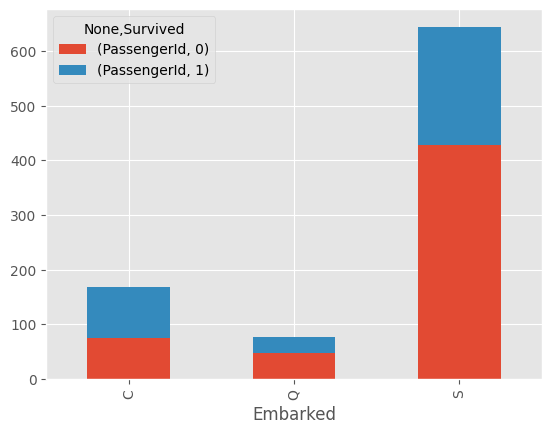

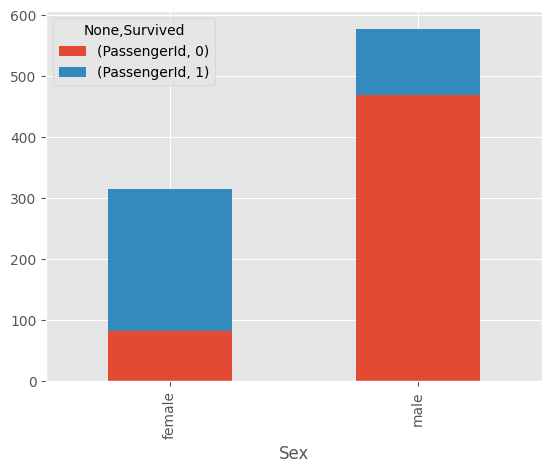

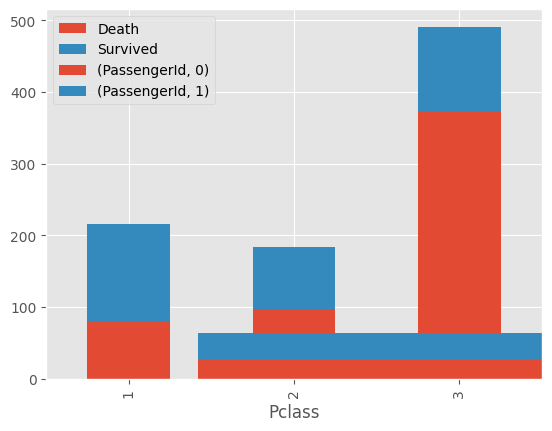

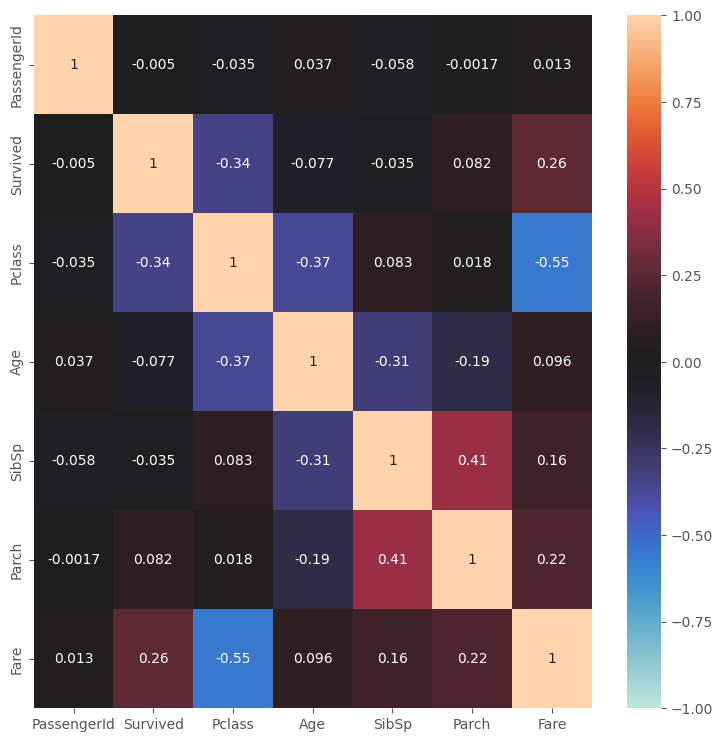

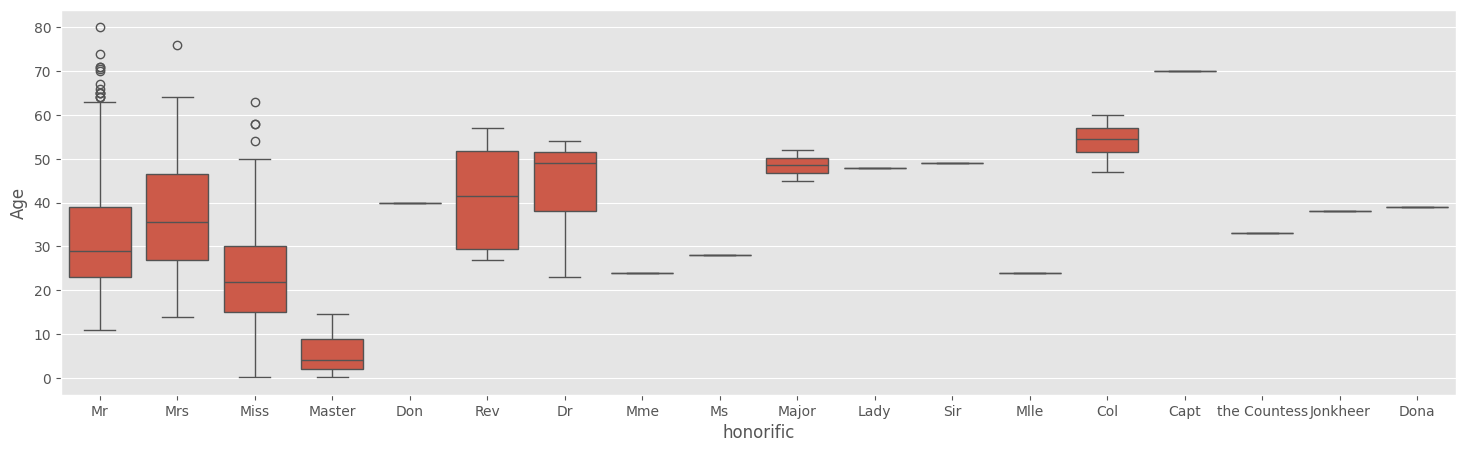

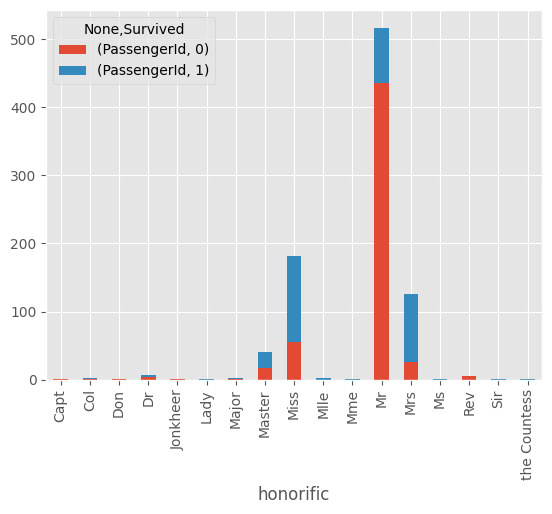

In [ ]:
# #### 本Notebookは書籍『Pythonで動かして学ぶ！Kaggleデータ分析入門』(翔泳社, 2020)の内容のサンプルコードとなります。
# ## 3.4　データ分析の準備をする
# ### ［手順4］ライブラリをインストール・インポートする
# #### Anaconda（Windows）、macOSの場合
# リスト3.1　ライブラリのインポート
import pandas as pd
import numpy as np
# ### ［手順5］データを読み込む
# #### Anaconda（Windows）、macOSの場合
# リスト3.2　データの読み込み
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/gender_submission.csv")
# リスト3.3　train.csvのデータの概要を表示
train_df
# リスト3.4　test.csvのデータの概要を表示
test_df
# リスト3.5　gender_submission.csvのデータの概要を表示
submission
# ### ［手順6］ランダムシードを設定する
# リスト3.7　ランダムシードの設定
import random
np.random.seed(1234)
random.seed(1234)
# ## 3.4　データの概要を把握する
# #### データ数を確認する
# リスト3.8　行数、列数の表示
print(train_df.shape)
print(test_df.shape)
# #### データの先頭行を確認する
# リスト3.9　データの中身の確認
pd.set_option("display.max_columns",50)
pd.set_option("display.max_rows",50)
train_df.head()
test_df.head()
# #### データの型を確認する
# リスト3.10　データ内の各列の値の型を参照
train_df.dtypes
# #### データの統計量を確認する
# リスト3.11　train.csvの数値データの概要を確認
train_df.describe()
# リスト3.12　test.csvの数値データの概要を確認
test_df.describe()
# #### カテゴリ変数を確認する
# リスト3.13　各カテゴリ変数の確認
train_df["Sex"].value_counts()
train_df["Embarked"].value_counts()
train_df["Cabin"].value_counts()
# #### 欠損値を確認する
# リスト3.14　各変数の欠損値の確認
train_df.isnull().sum()
test_df.isnull().sum()
# ## 3.6　データを可視化する
# #### 可視化用のライブラリをインストール・インポートする
# リスト3.15　データを可視化するライブラリのインポート
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# #### 表示結果の書式を指定する
# リスト3.16　ggplotを指定する
plt.style.use("ggplot")
# ### Survivedに関するデータを可視化する
# #### DataFrameから任意の列を抽出する
# リスト3.17　DataFrameからEmbarked、Survived、PassengerIdの列を抽出
train_df[["Embarked","Survived","PassengerId"]]
# #### 可視化したいデータから欠損値を除外する
# リスト3.18　可視化したいデータから欠損値を除外
train_df[["Embarked","Survived","PassengerId"]].dropna()
# #### EmbarkedとSurvivedの値で集計する
# リスト3.19　EmbarkedとSurvivedの値で集計
train_df[["Embarked","Survived","PassengerId"]].dropna().groupby(["Embarked","Survived"]).count()
# #### データを横持ちに変換する
# リスト3.20　データを横持ちに変換
embarked_df = train_df[["Embarked","Survived","PassengerId"]].dropna().groupby(["Embarked","Survived"]).count().unstack()
embarked_df
# #### 積み上げ縦棒グラフで可視化する
# リスト3.21　積み上げ縦棒グラフで可視化
embarked_df.plot.bar(stacked=True)
# #### 数値で確認する
# リスト3.22　新たにsurvived_rateという変数で数値を確認
embarked_df["survived_rate"]=embarked_df.iloc[:,0]/(embarked_df.iloc[:,0] + embarked_df.iloc[:,1])
embarked_df
# #### 性別やチケットの階級について可視化する
# リスト3.23　性別やチケットの階級を可視化
sex_df = train_df[["Sex","Survived","PassengerId"]].dropna().groupby(["Sex","Survived"]).count().unstack()
sex_df.plot.bar(stacked=True)
ticket_df = train_df[["Pclass","Survived","PassengerId"]].dropna().groupby(["Pclass","Survived"]).count().unstack()
ticket_df.plot.bar(stacked=True)
# #### 年代ごとの生存率をヒストグラムで可視化する
# リスト3.24　年代ごとの生存率をヒストグラムで可視化
# plt.hist((train_df[train_df["Survived"] == 0][["Age"]].values, train_df[train_df["Survived"] == 1][["Age"]].values),
# histtype="barstacked", bins=8, label=("Death", "Survive"))
# plt.legend()
age_dead      = train_df.loc[train_df["Survived"] == 0, "Age"].dropna()
age_survived  = train_df.loc[train_df["Survived"] == 1, "Age"].dropna()
plt.hist(
    [age_dead, age_survived], 
    histtype="barstacked",
    bins=8,
    label=("Death", "Survived")
    )
plt.legend()
# #### カテゴリ変数をダミー変数化する
# リスト3.25　カテゴリ変数をダミー変数化
train_df_corr = pd.get_dummies(train_df, columns=["Sex"],drop_first=True)
train_df_corr = pd.get_dummies(train_df_corr, columns=["Embarked"])
train_df_corr.head()
# #### 相関行列を作成する
# リスト3.26　相関行列の作成
# train_corr = train_df_corr.corr()
train_df_corr_selected = train_df_corr.select_dtypes(include=["number"])
train_corr = train_df_corr_selected.corr()
train_corr
train_corr
# #### ヒートマップで可視化する
# リスト3.27　ヒートマップで可視化
plt.figure(figsize=(9, 9))
sns.heatmap(train_corr, vmax=1, vmin=-1, center=0, annot=True)
# ## 3.7 前処理・特徴量の生成を行う
# #### 学習データとテストデータを統合する
# リスト3.28　学習データとテストデータを統合したものを作成
all_df = pd.concat([train_df, test_df],sort=False).reset_index(drop=True)
all_df
# ### 全体データで欠損値の数を確認する
# リスト3.29　全体データで欠損値の数を確認
all_df.isnull().sum()
# #### 欠損データを穴埋めする（Fare）
# リスト3.30　PclassごとのFareの平均値を計算
Fare_mean = all_df[["Pclass","Fare"]].groupby("Pclass").mean().reset_index()
# リスト3.31　カラム名の変更
Fare_mean.columns = ["Pclass","Fare_mean"]
Fare_mean
# リスト3.32　欠損値を置き換える
all_df = pd.merge(all_df, Fare_mean, on="Pclass",how="left")
all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
all_df = all_df.drop("Fare_mean",axis=1)
# #### Nameの敬称に注目する
# リスト3.33　Nameの欠損値を調べる
all_df["Name"].head(5)
# #### 敬称を変数として追加する
# リスト3.34　敬称を変数として追加
# name_df = all_df["Name"].str.split("[,.]",2,expand=True)
name_df = all_df["Name"].str.split(pat="[,.]", n=2, expand=True)
# リスト3.35　カラム名の変更
name_df.columns = ["family_name","honorific","name"]
name_df
# リスト3.36　先頭と末尾の空白文字の削除
name_df["family_name"] =name_df["family_name"].str.strip()
name_df["honorific"] =name_df["honorific"].str.strip()
name_df["name"] =name_df["name"].str.strip()
# #### 各敬称ごとの人数をカウントする
# リスト3.37　各honorific（敬称）ごとの人数をカウント
name_df["honorific"].value_counts()
# #### 敬称ごとの年齢分布を確認する
# リスト3.38　2つのDataFrameを横に結合
all_df = pd.concat([all_df, name_df],axis=1)
all_df
# リスト3.39　敬称ごとの年齢の分布を確認
plt.figure(figsize=(18, 5))
sns.boxplot(x="honorific", y="Age", data=all_df)
# #### 敬称ごとの年齢の平均値を確認する
# リスト3.40　敬称ごとの年齢の平均値を確認
all_df[["Age","honorific"]].groupby("honorific").mean()
# #### 敬称ごとの生存率の違いについて確認する
# リスト3.41　もとのDataFrameに名前のDataFrameを結合
train_df = pd.concat([train_df,name_df[0:len(train_df)].reset_index(drop=True)],axis=1)
test_df = pd.concat([test_df,name_df[len(train_df):].reset_index(drop=True)],axis=1)
# リスト3.42　敬称ごとにSurvivedの値ごとの人数を集計
honorific_df = train_df[["honorific","Survived","PassengerId"]].dropna().groupby(["honorific","Survived"]).count().unstack()
honorific_df.plot.bar(stacked=True)
# #### 年齢が欠損しているものは、敬称ごとの平均年齢で補完する
# リスト3.43　敬称ごとの平均年齢で年齢が欠損しているデータを穴埋めする
honorific_age_mean = all_df[["honorific","Age"]].groupby("honorific").mean().reset_index()
honorific_age_mean.columns = ["honorific","honorific_Age"]
all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_Age"]
all_df = all_df.drop(["honorific_Age"],axis=1)
# #### 家族人数を追加する
# リスト3.44　家族に関する変数を足して家族人数とする
all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]
all_df["family_num"].value_counts()
# #### 同船している家族人数が0人（1人乗船）かどうかを表すaloneという変数を追加する
# リスト3.45　1人か同船家族がいるかを変数に加える
all_df.loc[all_df["family_num"] ==0, "alone"] = 1
all_df["alone"].fillna(0, inplace=True)
# #### 不要な変数を削除する
# リスト3.46　不要な変数の削除
all_df = all_df.drop(["PassengerId","Name","family_name","name","Ticket","Cabin"],axis=1)
all_df.head()
# #### カテゴリ変数を数値に変換する
# リスト3.47　変数の型がobjectであるものをカテゴリ変数として管理
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)
# #### 敬称はMr、Miss、Mrs、Master以外は数が少ないため、 otherとして統合する
# リスト3.48　敬称はMr、Miss、Mrs、Master以外は数が少ないため、otherとして統合
all_df.loc[~((all_df["honorific"] =="Mr") |
    (all_df["honorific"] =="Miss") |
    (all_df["honorific"] =="Mrs") |
    (all_df["honorific"] =="Master")), "honorific"] = "other"
all_df.honorific.value_counts()
# #### 機械学習用のライブラリをインストール・インポートする
# リスト3.49　LabelEncoderのインポート
from sklearn.preprocessing import LabelEncoder
# リスト3.50　Label Encodingの実行①
all_df["Embarked"].fillna("missing", inplace=True)
all_df.head()
le = LabelEncoder()
le = le.fit(all_df["Sex"])
all_df["Sex"] = le.transform(all_df["Sex"])
# リスト3.51　Label Encodingの実行②
for cat in categories:
    le = LabelEncoder()
    print(cat)
    if all_df[cat].dtypes == "object":    
        le = le.fit(all_df[cat])
        all_df[cat] = le.transform(all_df[cat])
all_df.head()
# #### すべてのデータを学習データとテストデータに戻す
# リスト3.52　train/testデータセットにデータを戻す
train_X = all_df[~all_df["Survived"].isnull()].drop("Survived",axis=1).reset_index(drop=True)
train_Y = train_df["Survived"]
test_X = all_df[all_df["Survived"].isnull()].drop("Survived",axis=1).reset_index(drop=True)


In [148]:

# ## 3.8 モデリングを行う
# #### LightGBMのライブラリをインストール・インポートする
# リスト3.53　LightGBMのライブラリのインポート
import lightgbm as lgb
# #### ホールドアウト、クロスバリデーションを行うための ライブラリをインポートする
# リスト3.54　ホールドアウト、クロスバリデーションを行うためのライブラリをインポート
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# #### 学習データの20%を検証データに分割する
# リスト3.55　学習データの20%を検証データに分割する
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2)
# #### LightGBM用のデータセットを作成する
# リスト3.56　カテゴリ変数を指定してLightGBM用のデータセットを作成
categories = ["Embarked", "Pclass", "Sex","honorific","alone"]
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(X_valid, y_valid,  categorical_feature=categories, reference=lgb_train)
# #### ハイパーパラメータを設定する
# リスト3.57　ハイパーパラメータの設定
lgbm_params = {
    "objective":"binary",        
    "random_seed":1234
}
# #### LightGBMによる機械学習モデルを学習させる
# リスト3.58　機械学習モデルの学習
# model_lgb = lgb.train(lgbm_params, 
#                       lgb_train, 
#                       valid_sets=lgb_eval, 
#                       num_boost_round=100,
#                       early_stopping_rounds=20,
#                       verbose_eval=10)
model_lgb = lgb.train(
    lgbm_params,
    lgb_train,
    valid_sets=lgb_eval,
    num_boost_round=100,
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(period=10)]
    )


[LightGBM] [Info] Number of positive: 272, number of negative: 440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382022 -> initscore=-0.480973
[LightGBM] [Info] Start training from score -0.480973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [149]:

# #### 各変数の重要度を調べる
# リスト3.59　各変数の重要度の確認
model_lgb.feature_importance()


array([ 34,  19, 184,  20,   8, 241,  27,   3,  19,   0], dtype=int32)

<Axes: >

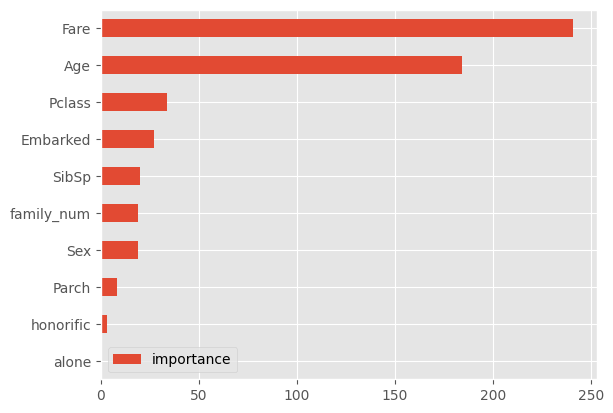

In [150]:

# リスト3.60　もとのデータのカラム名を表示
importance = pd.DataFrame(model_lgb.feature_importance(), index=X_train.columns, columns=["importance"]).sort_values(by="importance",ascending =True)
importance.plot.barh()


In [151]:

# ### 検証データで予測精度を確認
# #### モデルを検証データに適用する
# リスト3.61　モデルを検証データに適用
y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)

In [152]:
# train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
# train_Y = train_df["Survived"]

In [153]:
# 学習データの20％を検証データの分割する

# X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2)

In [154]:
# LightGBM用のデータセットを作成

# categories = ["Embarked", "Pclass", "Sex", "honorific", "alone"]

# lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
# lgb_eval = lgb.Dataset(X_train, y_train, categorical_feature=categories, reference=lgb_train)

In [155]:
# ハイパーパラメーターを設定する

# lgbm_params = {
#     "objective": "binary",
#     "random_seed": 1234
# }

In [156]:
# LightGBMによる機械学習モデルを学習させる

# model_lgb = lgb.train(
#     lgbm_params,
#     lgb_train,
#     valid_sets=lgb_eval,
#     num_boost_round=100,
#     callbacks=[lgb.early_stopping(20), lgb.log_evaluation(period=10)]
#     )

In [157]:
# 各変数の重要度を調べる

# model_lgb.feature_importance()

In [158]:
# importance = pd.DataFrame(model_lgb.feature_importance(), index=X_train.columns, columns=["importance"]).sort_values(by="importance", ascending=True)
# importance.plot.barh()

In [159]:
# モデルを検証でーたに適用する

# y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)

## 予測精度を計測する

Titanicコンペの評価指標は、　accuracy。

- True Positive: 真陽性
- False Negative: 偽陰性
- False Positive: 偽陽性
- True Negative: 真陰性

accuracy = (TP + TN) / (TP + TN + FP + FN)

In [160]:
from sklearn.metrics import accuracy_score

# 精度計測
accuracy_score(y_valid, np.round(y_pred))

0.8435754189944135

### ハイパーパラメータを変更する

- learning_rate
- max_bin
- num_leaves
- min_data_in_leaf

In [161]:
# ハイパーパラメータの変更
lgbm_params_2 = {
    "objective":"binary",
    "max_bin":331,
    "num_leaves": 20,
    "min_data_in_leaf": 57,
    "random_seed":1234
}


In [162]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categories, reference=lgb_train)

In [163]:
model_lgb_2 = lgb.train(
    lgbm_params_2,
    lgb_train,
    valid_sets=lgb_eval,
    num_boost_round=100,
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(10)]
    )

[LightGBM] [Info] Number of positive: 272, number of negative: 440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382022 -> initscore=-0.480973
[LightGBM] [Info] Start training from score -0.480973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [164]:
y_pred_2 = model_lgb_2.predict(X_valid, num_iteration=model_lgb.best_iteration)

In [ ]:
accuracy_score(y_valid, np.round(y_pred_2))

# no1 0.8435754189944135
# no2 0.0.8491620111731844

0.8491620111731844